In [1]:
import glob
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.distances import distance_array
from matplotlib import pyplot as plt
import pandas as pd
from collections import OrderedDict,Counter
from operator import itemgetter
import difflib
import re
import pickle
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN,KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy import stats
import mdtraj as md
from sklearn.decomposition import PCA
import os
import shutil
import subprocess
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import itertools
import statsmodels.api as sm
import seaborn as sns
import math
import py3Dmol
import mdtraj
from operator import itemgetter
from IPython.display import Image


/opt/homebrew/anaconda3/envs/my-rdkit-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/adelielouet/.local/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


/opt/homebrew/anaconda3/envs/my-rdkit-env/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not monotonically increasing
  warnings.warn('atom_indices are not monotonically increasing')


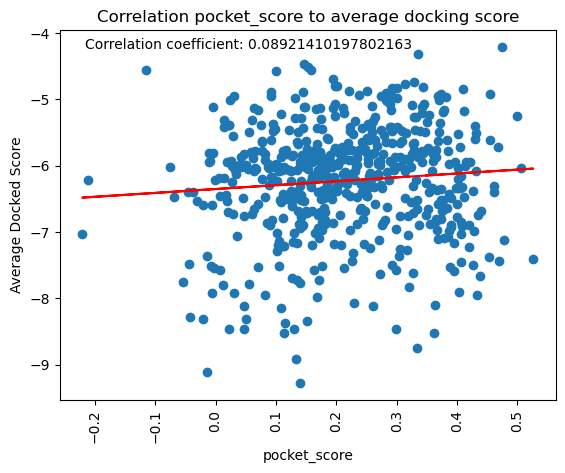

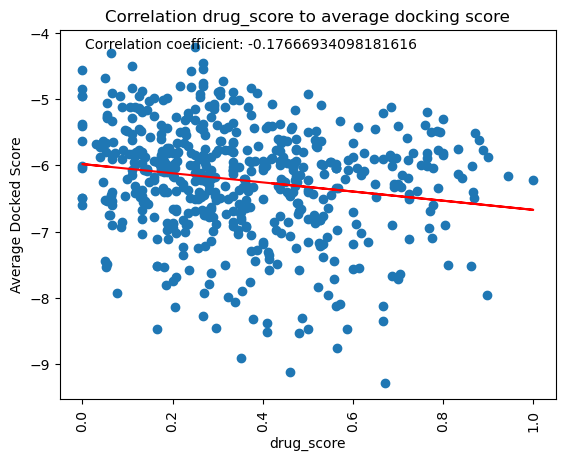

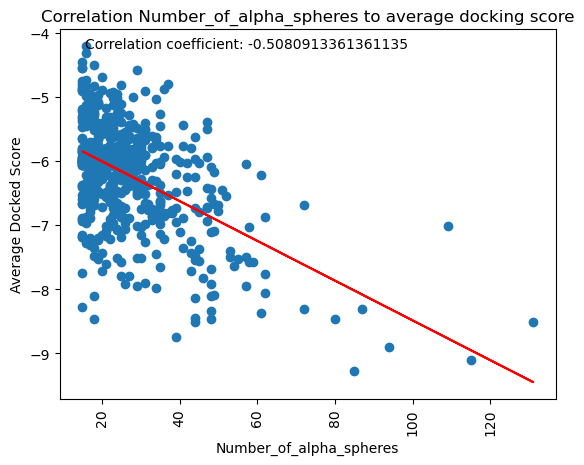

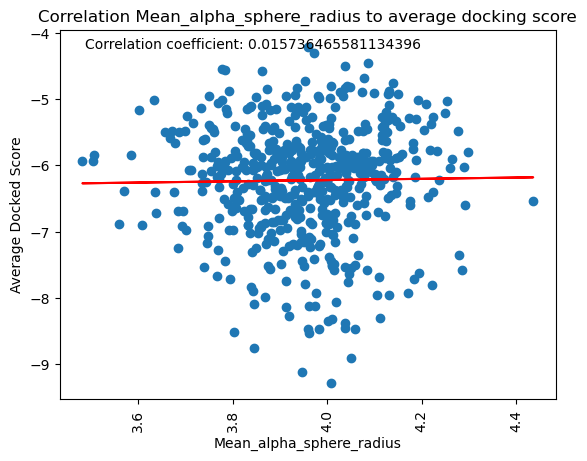

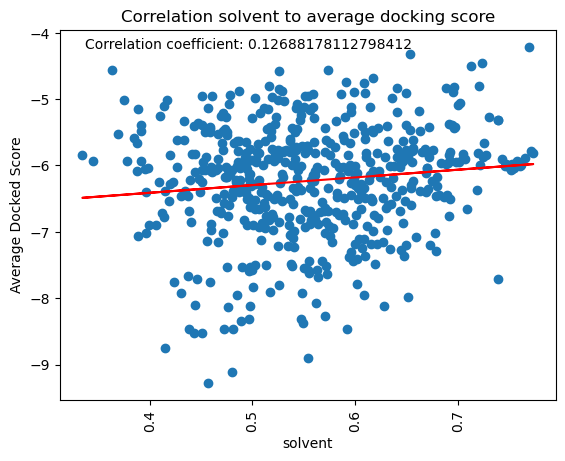

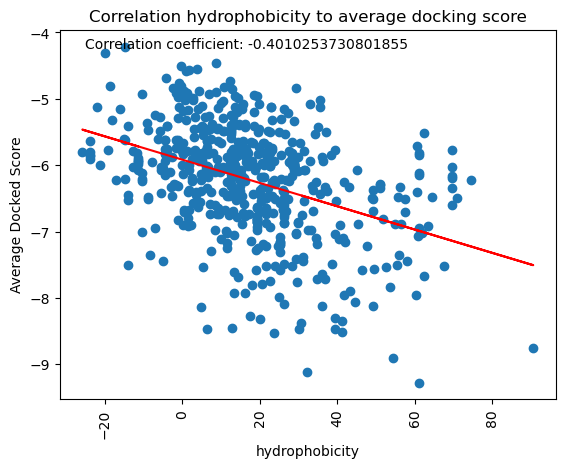

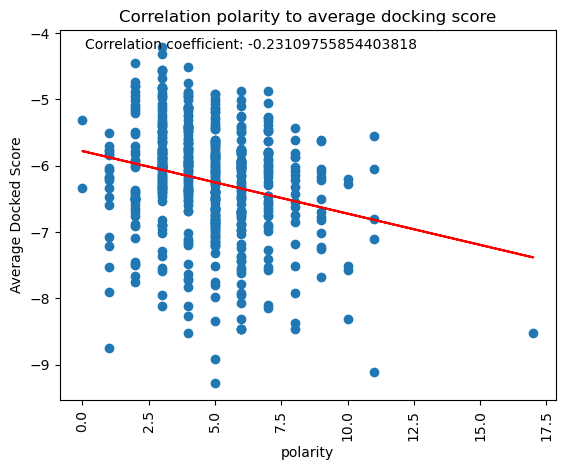

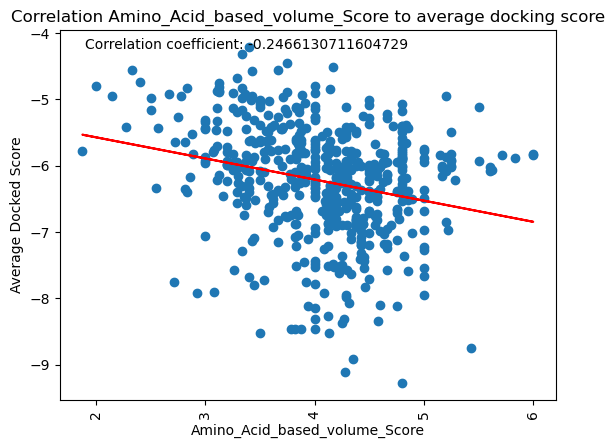

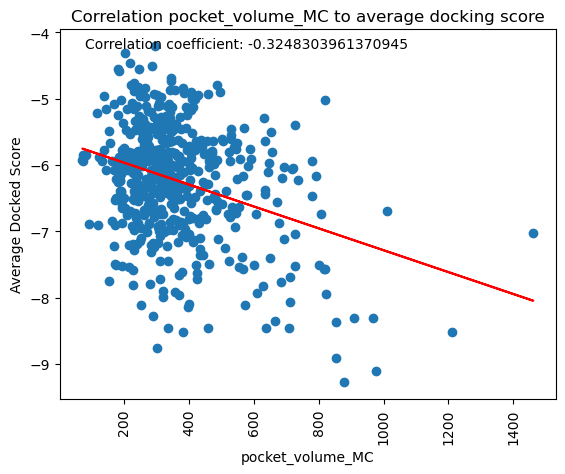

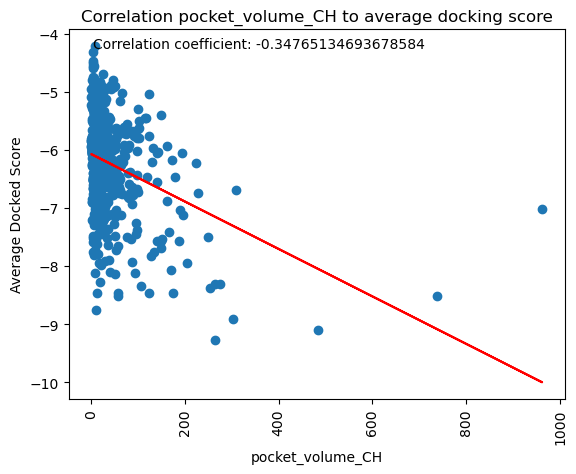

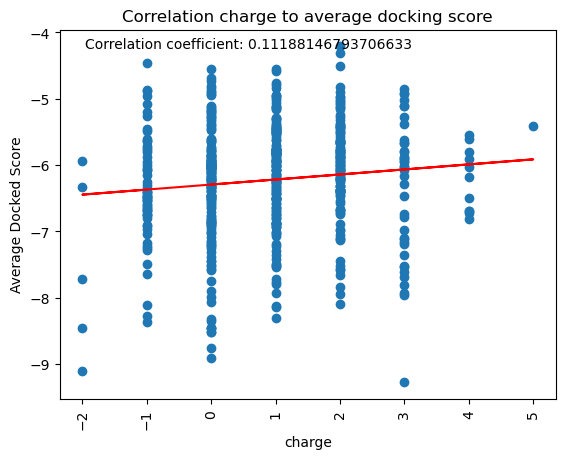

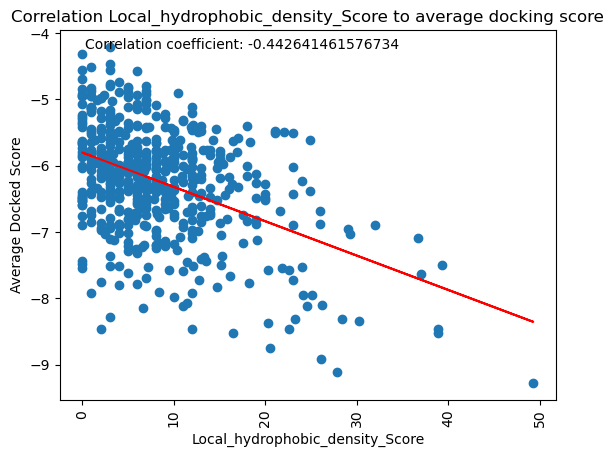

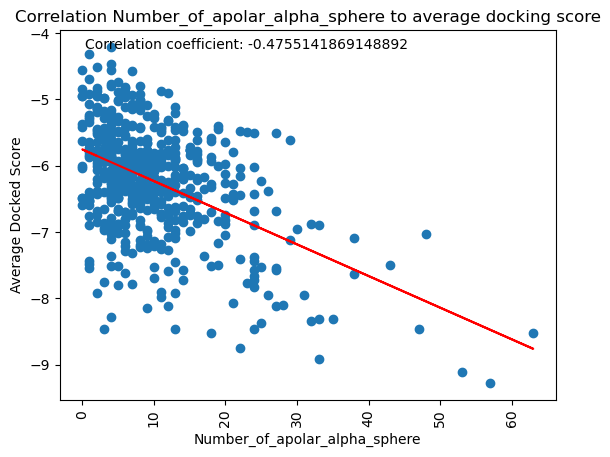

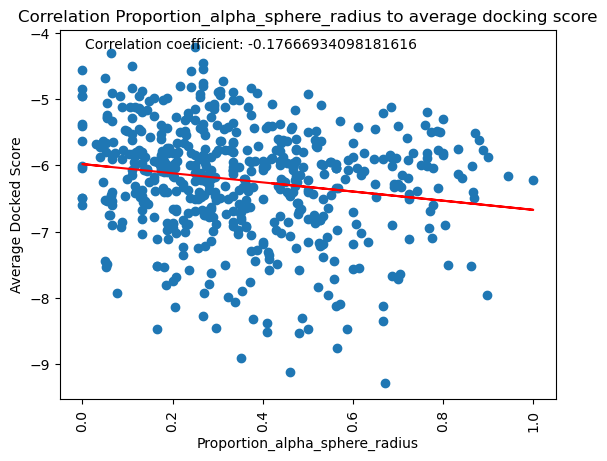

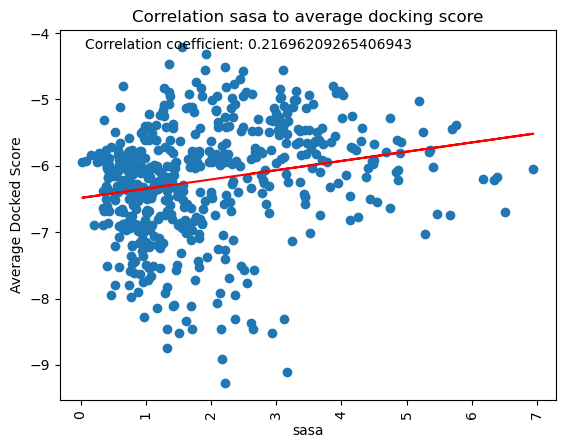

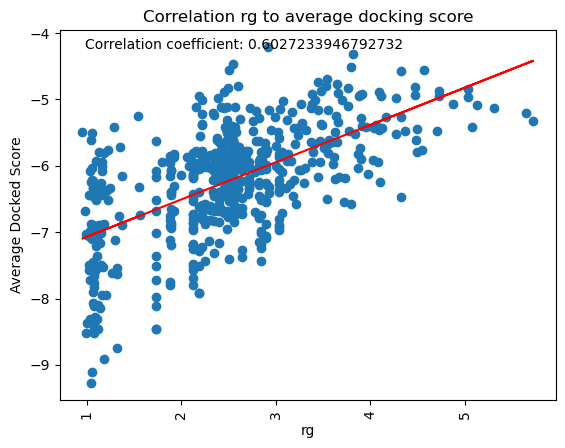

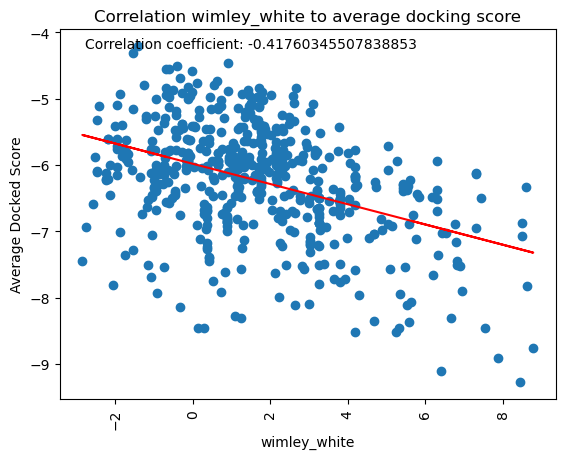

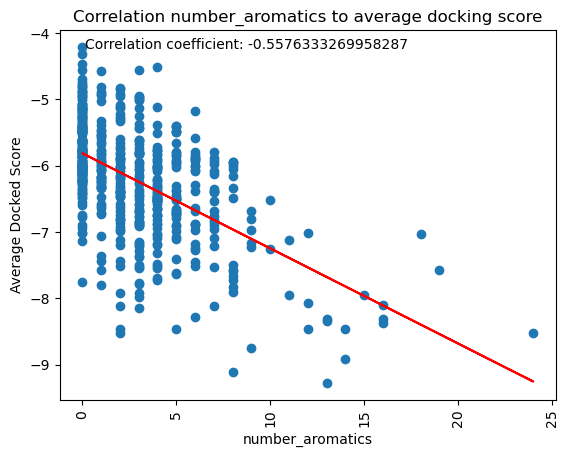

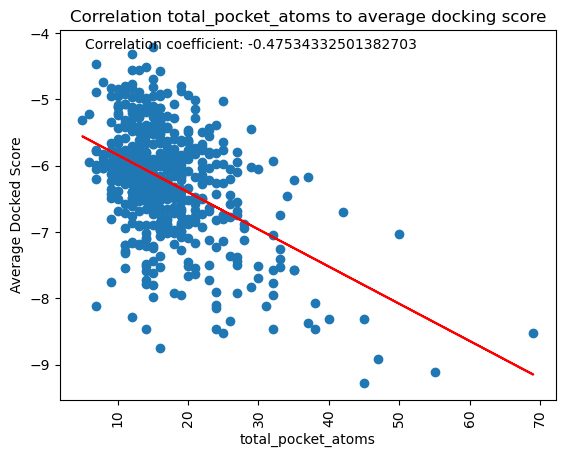

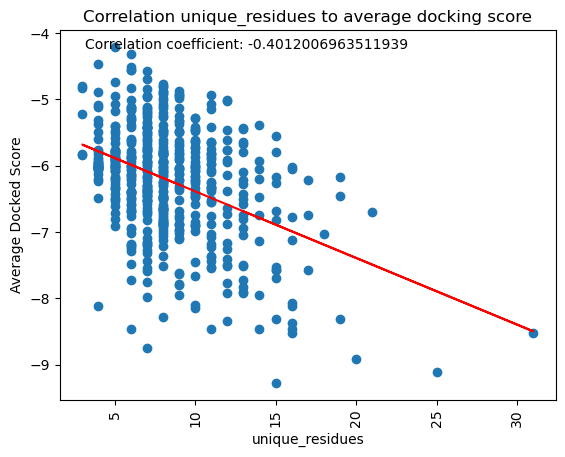

In [2]:
%run -i scrapping_feautures.py 


Need to have already ran the scrapping_feautres.py first to have the regress_df<br>
The following script is used to predict the ligand movement on protein surface based on ki values previously predicted via linear regression

 Now actually running this simple formula on various tranches of data to see what it looks like:

In [3]:
x1 = regress_df['rg'].to_numpy()
x2 = regress_df['hydrophobicity'].to_numpy()
x3=regress_df['number_aromatics'].to_numpy()
#x4=regress_df['polarity'].to_numpy()
X=np.column_stack([x1,x2,x3])
y = regress_df['Avg_dock_score'].to_numpy()

X=np.column_stack([x1,x2,x3])
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

#### Using stratification to test how reliable our Epred is:

In [4]:
# scores=[] 
# rmse_list=[] 
# cv = KFold(n_splits=10, random_state=42, shuffle=True)

# #reg.coef_=([ 0.46248464, -0.01613283, -0.16386205])
# #reg.intercept_ = 0 

# for train_index, test_index in cv.split(X):<
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     x1_train = list(map(itemgetter(0), X_train))
#     x2_train = list(map(itemgetter(1), X_train))
#     x3_train = list(map(itemgetter(2), X_train))

#     y_pred_multiple = reg.intercept_ + reg.coef_[0] * np.array(x1_train) + reg.coef_[1] * np.array(x2_train) + reg.coef_[2] * np.array(x3_train)
#     #print(len(y_train),len(y_test))
#     correlation_matrix = np.corrcoef(y_train, y_pred_multiple)<br>
#     correlation_coefficient = correlation_matrix[0, 1]<br>
#     print(correlation_coefficient)

### Caluclating dependent variables
##### Hydrophobicity, rg, number_of_aromatics

In [5]:
monera_hodges = {
    'ALA': 41.0,
    'ARG': -14.0,
    'ASN': -28.0,
    'ASP': -55.0,
    'CYS': 49.0,
    'GLN': -10.0,
    'GLU': -31.0,
    'GLY': 0.0,
    'HIS': 8.0,
    'ILE': 99.0,
    'LEU': 97.0,
    'LYS': -23.0,
    'MET': 74.0,
    'PHE': 100.0,
    'PRO': -46.0,
    'SER': -5.0,
    'THR': 13.0,
    'TRP': 97.0,
    'TYR': 63.0,
    'VAL': 76.0
} #https://onlinelibrary.wiley.com/doi/abs/10.1002/psc.310010507

In [6]:
aromatic_pairs=['PHE','TYR','TRP','HIS']

In [7]:
# <!-- Trying to match one of these centorids with fpocket to compare and contrast<br>
# centroid_pair3_tau=[26.421680664383246, -8.794966277436163, -5.197273656539529] -->

# def distance(x1, y1, z1, x2, y2, z2): 
     
#     d = math.sqrt(math.pow(x2 - x1, 2) +
#                 math.pow(y2 - y1, 2) +
#                 math.pow(z2 - z1, 2)* 1.0)
#     return(d) 

# distances=[]
# for x1,y1,z,name in zip(df_centroid['x'],df_centroid['y'],df_centroid['z'],df_centroid['residue']):
#     dis=[name,distance(x1, y1, z1,centroid_pair3_tau[0], centroid_pair3_tau[1], centroid_pair3_tau[2])]
#     distances.append(dis)

# print(sorted(distances, key = lambda x: int(x[1]))) # shows it in order<br>
#Can't really figre it out because the fpocket pockets are smack in the middle of a groove whereas these are on the actual chain

# [[PHE104, 14.530402634926888] closes one to pair3_abeta<br>
#comapring both regress_df.loc['pair3_STP_1_tau'] & df_centroid.iloc[30]


### Now actually trying to trail a path & visualizing using py3dmol and pandas

In [8]:
# finding line of best fit
alpha = regress_df['rg'].to_numpy()
beta = regress_df['hydrophobicity'].to_numpy()
gamma=regress_df['number_aromatics'].to_numpy()
#x4=regress_df['polarity'].to_numpy()

X=np.column_stack([alpha,beta,gamma])
y = regress_df['Avg_dock_score'].to_numpy()

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

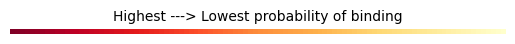

This is showing protein tau pocket pair3


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

This is showing protein abeta pocket pair22


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:

count=0
for column in analysis_df.columns[::500]:
    count+=1
    protein=column.split('_')[-1]
    pair=column.split('_')[0]
    stp_number=column.split('_')[-2]
    if protein=='tau':
        pocket_pdb=path_fpocket+protein+'/ensemble/fpocket/'+pair+"_out/"+pair+"_out.pdb"
        original_pdb=path_fpocket+protein+'/ensemble/fpocket'+'/'+pair+'.pdb'
    elif protein=='abeta':
        pocket_pdb=path_fpocket+protein+'/ensemble_100/fpocket/'+pair+"_out/"+pair+"_out.pdb"
        original_pdb=path_fpocket+protein+'/ensemble_100/fpocket'+'/'+pair+'.pdb'
    else:
        pocket_pdb=path_fpocket+protein+'/ensemble/fpocket/'+pair+"_out/"+pair+"_out.pdb"
        #print(pocket_pdb)
        original_pdb=path_fpocket+protein+'/ensemble/fpocket/'+pair+'.pdb'

    # df_pdb = pd.DataFrame(columns=columns)

    # with open(original_pdb) as file:
    #     for line in file:
    #         if 'ATOM' in line:
    #             sep=line.split(' ')
    #             str_list = list(filter(None, sep))
    #             del str_list[-1]

    #             if len(str_list)==10:
    #                 str_list.insert(4,'A') 
    #                 str_list.insert(12,'O')
    #             else:
    #                 pass
    #             df = pd.DataFrame([str_list], columns=columns)
    #             df_pdb = pd.concat([df_pdb, df], ignore_index=True)

    traj_original_pdb = md.load(original_pdb)
    rg=md.compute_rg(traj_original_pdb, masses=None)[0]
    aromatic_pairs=['PHE','TYR','TRP','HIS']

    com_residues=[]
    hydroscore=[]
    number_aromatics=[]
    resii=[]
    number_atoms=[]
    cutoff=0.3

    traj_original_pdb = md.load(original_pdb)
    topology = md.load_topology(original_pdb)
    resid_num =  list(range(1,(traj_original_pdb.n_residues+1)))#df_pdb['resid'].unique()
    for res in resid_num:
        resi = traj_original_pdb.topology.residue((int(res))-1)
        atom_indices = [atom.index for atom in resi.atoms]
        resii.append(resi)

        #finding com
        com = (md.compute_center_of_mass(traj_original_pdb.atom_slice(atom_indices))).tolist()
        #com=com.tolist()
        com=(list(map(lambda x:x*10,com[0])))
        com_residues.append(com)

        #finding hydrophobocity score
        neighbors=mdtraj.compute_neighbors(traj_original_pdb, cutoff, atom_indices, haystack_indices=None, periodic=True)
        atom_indices_neighbors=neighbors[0].tolist()

        def remove_numbers(residue_list):
            return [re.sub(r'\d+', '', residue) for residue in residue_list]

        residues = {topology.atom(index).residue for index in atom_indices_neighbors}

        #residue_names = {topology.atom(index).residue.name for index in atom_indices_neighbors}
        residue_names = [str(residue) for residue in residues]
        clean_residues = remove_numbers(residue_names)
        hydro=(np.array(list((monera_hodges.get(residue)) for residue in clean_residues))).mean()
        hydroscore.append(hydro)

        number_atoms_=len(atom_indices_neighbors)
        number_atoms.append(number_atoms_)

        aromaticity=len([w for w in clean_residues if w in aromatic_pairs])
        number_aromatics.append(aromaticity)


    df_centroid=pd.DataFrame(com_residues,columns=['x','y','z'])
    df_centroid.insert(0, 'residue', resii) 
    df_centroid['hydrophobicity_score']=hydroscore
    df_centroid['number_aromatics']=number_aromatics
    df_centroid['number_atoms']=number_atoms

    #print(df_centroid)
    x2 = df_centroid['hydrophobicity_score'].to_numpy()
    x3=df_centroid['number_aromatics'].to_numpy()
    x1 = np.array([rg]*len(x2))

    E_pred=reg.intercept_ + reg.coef_[0] * x1 + reg.coef_[1] * x2+reg.coef_[2]*x3
    df_centroid['E_pred']=E_pred

    df_centroid=df_centroid.sort_values(by=['E_pred'])
    
    if count==1:
        colorpalette = sns.color_palette("YlOrRd", as_cmap=True)
        colorpalette = colorpalette.reversed()
        data = np.array(list(range(0, 100))).reshape(1, 100)
        plt.imshow(data, cmap=colorpalette)
        plt.axis('off')
        plt.title('Highest ---> Lowest probability of binding', fontsize=10)
        plt.show()

    number_colors=len(df_centroid)
    colorpalette = sns.color_palette("YlOrRd", number_colors)
    colorpalette.reverse()

    with open(pocket_pdb) as ifile:
        system = "".join([x for x in ifile])

    label=original_pdb.split('/')[-4]
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(system)

    for residue, color in zip(df_centroid['residue'], colorpalette):
        resi = int(''.join(c for c in str(residue) if c.isdigit() or c == '.'))
        c_hex = '#%02x%02x%02x' % tuple(int(255 * x) for x in color)
        view.setStyle({'resi': resi}, {"cartoon": {'color': c_hex}})
    #view.setStyle({'resn': "STP"}, {"sphere": {'color': 'lightblue','opacity':0.5}})
    view.setStyle({'resn': "STP","resi":1}, {"sphere": {'color': 'lightblue','opacity':0.6}})

    view.zoomTo()
    print('This is showing protein',protein, 'pocket',pair)

    view.show()

    

    view.zoomTo()
    #view.png('/mnt/data/protein_' + str(count) + '.png')

In [25]:
view.png()